In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import warnings
from privacygan import privacy_gan as pg
from privacygan.cifar import cifar_gan
from datetime import datetime

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__, "device:", device)


/data/miniconda/envs/privGAN/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.4.1 device: cpu


In [2]:
# Load CIFAR10 data and concatenate the train+test set using torchvision
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

X_train = (torch.tensor(train_ds.data).float() - 127.5) / 127.5
X_test = (torch.tensor(test_ds.data).float() - 127.5) / 127.5
X_train = X_train.permute(0, 3, 1, 2).numpy()
X_test = X_test.permute(0, 3, 1, 2).numpy()
X_all = np.concatenate((X_train, X_test))

# Generate training/test split
frac = 0.1
n = int(frac * len(X_all))
idx = np.random.permutation(len(X_all))
X = X_all[idx[:n]]
X_comp = X_all[idx[n:]]

print('training set size:', X.shape)
print('test set size:', X_comp.shape)


Files already downloaded and verified
Files already downloaded and verified
training set size: (6000, 3, 32, 32)
test set size: (54000, 3, 32, 32)


In [3]:
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(
    X,
    generator=cifar_gan.CIFAR_Generator(),
    discriminator=cifar_gan.CIFAR_Discriminator(),
    epochs=1,
    batchSize=128,
)


Epochs: 1
Batch size: 128
Batches per epoch: 46
epoch = 1/1, d_loss=0.905, g_loss=1.7265, g_loss=7.539


In [4]:
# Perform white box attack
Acc = pg.WBattack(X, X_comp, discriminator)

White-box attack accuracy: 0.09783333333333333


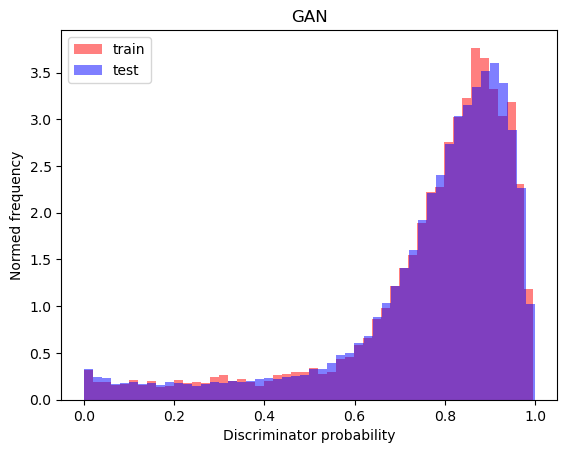

In [5]:
with torch.no_grad():
    scores_train = discriminator(torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy().squeeze()
    scores_test = discriminator(torch.tensor(X_comp, dtype=torch.float32, device=device)).cpu().numpy().squeeze()

plt.hist(scores_train, color='r', alpha=0.5, label='train', density=True, bins=50)
plt.hist(scores_test, color='b', alpha=0.5, label='test', density=True, bins=50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

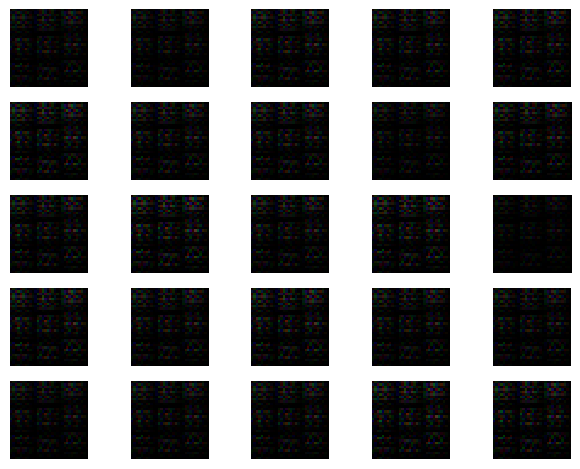

In [6]:
# Generate fake images
pg.DisplayImages(generator, figSize=(5,5), NoImages=25, TargetShape=(32,32,3))

In [7]:
### Test privGAN (with n_reps = 2)
generators = [cifar_gan.CIFAR_Generator(), cifar_gan.CIFAR_Generator()]
discriminators = [cifar_gan.CIFAR_Discriminator(), cifar_gan.CIFAR_Discriminator()]
pDisc = cifar_gan.CIFAR_DiscriminatorPrivate(OutSize=2)

(generators, discriminators, _, dLosses, dpLosses, gLosses) = pg.privGAN(
    X,
    epochs=1,
    disc_epochs=1,
    batchSize=128,
    generators=generators,
    discriminators=discriminators,
    pDisc=pDisc,
    privacy_ratio=1.0,
)


dp-Accuracy: 0.523
Epochs: 1
Batch size: 128
Batches per epoch: 24
epoch = 0/1, batch = 24/24
dLosses = [1.00680624 1.07153082]
dpLosses = 0.0
gLosses = 2.8962997049093246
dp-Accuracy: 0.5


In [8]:
# Perform white box attack for privGAN
pg.WBattack_priv(X, X_comp, discriminators)

White-box attack accuracy (max): 0.09616666666666666
White-box attack accuracy (mean): 0.1


(0.09616666666666666, 0.1)

In [9]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.09616666666666666
White-box attack accuracy (mean): 0.1


(0.09616666666666666, 0.1)

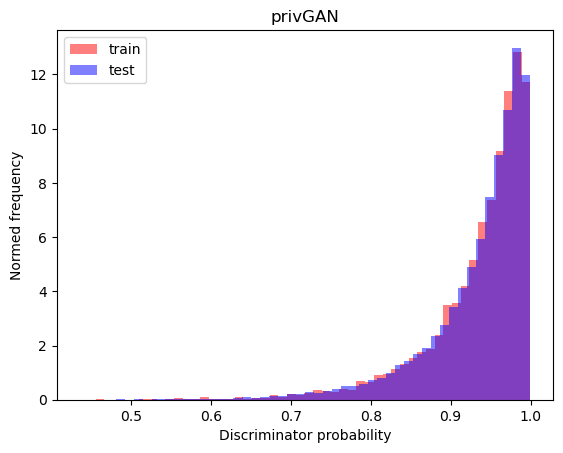

In [10]:
with torch.no_grad():
    scores_train = discriminators[0](torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy().squeeze()
    scores_test = discriminators[0](torch.tensor(X_comp, dtype=torch.float32, device=device)).cpu().numpy().squeeze()

plt.hist(scores_train, color='r', alpha=0.5, label='train', density=True, bins=50)
plt.hist(scores_test, color='b', alpha=0.5, label='test', density=True, bins=50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN')
plt.legend()


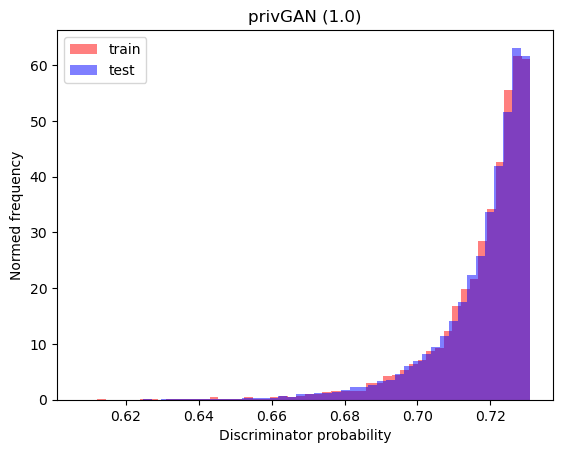

In [12]:
with torch.no_grad():
    x_tr = torch.tensor(X, dtype=torch.float32, device=device)
    x_te = torch.tensor(X_comp, dtype=torch.float32, device=device)
    out_tr = discriminators[0](x_tr)
    out_te = discriminators[0](x_te)
    # 若判别器输出未经过 sigmoid，则转为概率再取到 CPU
    try:
        probs_tr = torch.sigmoid(out_tr).detach().cpu().numpy().squeeze()
        probs_te = torch.sigmoid(out_te).detach().cpu().numpy().squeeze()
    except Exception:
        probs_tr = out_tr.detach().cpu().numpy().squeeze()
        probs_te = out_te.detach().cpu().numpy().squeeze()

plt.hist(probs_tr, color='r', alpha=0.5, label='train', density=True, bins=50)
plt.hist(probs_te, color='b', alpha=0.5, label='test', density=True, bins=50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN (1.0)')
plt.legend()


In [ ]:
pg.WBattack_priv(X,X_comp, discriminators)

In [ ]:
torch.cuda.empty_cache()